In [1]:
device = "cuda:0"

In [2]:
# Generate datasets
from multiprocessing import Process
import multiprocessing as mp
import math
from functools import partial
from pathlib import Path
from typing import Any

import clip
import numpy as np
import torch
import typer
from joblib import Parallel, delayed
from PIL import Image
from tqdm import tqdm
from torchvision import transforms


def load_sg(network_pkl):
    import sys
    sys.path.append("stylegan3")
    import dnnlib
    import legacy

    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'] # type: ignore
    return G

generators = {
    "sg2-ffhq-1024": partial(load_sg, 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl'),
    "sg3-lhq-256": partial(load_sg, 'data/models/lhq-256-stylegan3-t-25Mimg.pkl'),
}


/home/jpinkney/miniconda3/envs/clip2latent/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append("stylegan3")
import dnnlib
import legacy
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl'
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'] # type: ignore


In [4]:
import matplotlib.pyplot as plt
import torch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


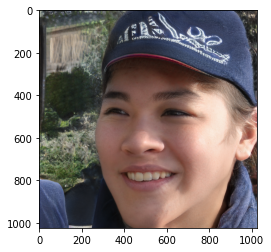

In [76]:
with torch.no_grad():

    z = torch.randn(8, 512, device=device)
    G.to(device)
    w = G.mapping(z, c=None)
    
    # w_comp = [w[x,0,:].unsqueeze(0).tile(1,t,1) for x, t in enumerate((4,4,10))]
    # w_comp = torch.cat(w_comp, dim=1)
    w_comp = mix_latents(w)
    out = G.synthesis(w_comp)
    
im = out[0].permute(1,2,0).cpu()* 0.5 + 0.5
plt.imshow(im)
plt.show()

In [67]:

def mix_latents(w_batch):
    bs = w_batch.shape[0]
    spec = torch.tensor((4, 4, 10)).to(w_batch.device)

    index = torch.randint(0,bs, (len(spec),bs)).to(w_batch.device)
    return w_batch[index, 0, :].permute(1,0,2).repeat_interleave(spec, dim=1)


In [11]:
w.shape

torch.Size([10, 18, 512])